In [5]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from autograd.misc import flatten
import numpy as np
import autograd.numpy as anp
from autograd import value_and_grad
from numpy import array_split
from numpy.random import choice
from numpy.linalg import solve
import matplotlib.pyplot as plt
import pandas as pd
from autograd import jacobian

## Utils

In [6]:
def init_hyper_param():
    """
    Initialize Hyper Parameters
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sequence_length = 28
    input_size = 28
    hidden_size = 14
    num_layers = 2
    num_classes = 10
    batch_size = 40
    return device,sequence_length,input_size,hidden_size,num_layers,num_classes,batch_size


def transform_image_data(batch_size):
    """
    Load and Transform Mnist Data Set into Batches
    """
    train_dataset = torchvision.datasets.MNIST(root=os.getcwd(),
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
    test_dataset = torchvision.datasets.MNIST(root=os.getcwd(),
                                              train=False, 
                                              transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size, 
                                              shuffle=True)
    return train_loader,test_loader



def one_hot_encoding(labels,num_classes=10):
    """
    One Hot Encoding
    """
    temp = np.zeros([len(labels),num_classes])
    for i in range(len(labels)):
        temp[i][int(labels[i])] = 1
    return torch.from_numpy(temp)


def Flatten_Params(NN):
    """
    Flatten the Parameters of a Given Model
    """
    Parameters_Flattened = list(NN.parameters())[0].reshape(-1,1)
    for i in range(1,len(list(NN.parameters()))):
        Parameters_Flattened = torch.cat((Parameters_Flattened,list(NN.parameters())[i].reshape(-1,1)))
    return Parameters_Flattened

def Flatten_Grad(Gradient):
    """
    Flatten the Gradient
    """
    Parameters_Flattened = list(Gradient)[0].reshape(-1,1)
    for i in range(1,len(Gradient)):
        Parameters_Flattened = torch.cat((Parameters_Flattened,Gradient[i].reshape(-1,1)))
    return Parameters_Flattened



def unflatten_param(Flat_Param,NN):
    """
    Update the Model Parameters given by a Flattened Array
    """
    Prev = 0
    for parameter in NN.parameters():
        if len(parameter.data.shape)>1:
            New = Prev + (parameter.data.shape[0] * parameter.data.shape[1] )
            parameter.data = Flat_Param[Prev:New].reshape(parameter.data.shape)
            Prev =New
        else:
            New = Prev + parameter.data.shape[0]
            parameter.data = Flat_Param[Prev:New].reshape(parameter.data.shape)
            Prev = New
    
    return NN


def next_mini_batch(dataset,batch_size,sequence_length,input_size,low,high):
    """
    Next Mini Batch
    """
    
    X_batch = torch.zeros(batch_size,sequence_length,input_size)
    y_batch = torch.zeros(batch_size)
    Key = np.random.randint(low=low,high=high,size=batch_size)
    i = 0
    for element in Key:
        X_batch[i] = dataset[element][0].reshape(sequence_length,input_size)
        y_batch[i] = dataset.train_labels[element]
        i+=1
    return X_batch,y_batch

def Cal_Accuracy(model,data_set,batch_size,sequence_length,input_size):
    """
    Calculate the Accuracy
    """
    X_batch,y_batch = next_mini_batch(data_set,batch_size,sequence_length,input_size,low=50000,high=60000)
    output = model(X_batch)
    output = torch.max(output,1)[1]
    return (np.sum(output.detach().numpy()==y_batch.detach().numpy())/(batch_size)) * 100


def Valid_Accuracy(model,data_set,batch_size,sequence_length,input_size):
    """Calculate the Avergae Accuracy over an iteration of 500 Batches"""
    iters = 600
    accuracy = torch.zeros(iters)
    for i in range(iters):
        accuracy[i] = Cal_Accuracy(model,data_set,batch_size,sequence_length,input_size)
    return accuracy.detach().numpy()

## Neural Network

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,device):
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
      #  self.lsmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        #x = torch.transpose(x,1,2)
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        #
      #  out = self.lsmax(out)
        
        return out


def random_initialization_neural_networks(in_size,h_size,n_layers,n_classes,device):
    """
    Initialize the Weights 
    """
    lstm_model = RNN(in_size, h_size, n_layers, n_classes,device).to(device)
    weight = Flatten_Params(lstm_model)
    torch.manual_seed(0)
    Normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.1]))
    weight = Normal.sample((len(weight),))
    lstm_model = unflatten_param(weight,lstm_model)
    return lstm_model,weight


def squared_loss(NN, inputs, targets,Flattened_Param ,C):
    """
    Regularized squared loss
    """
    L = 0
    regularizer = 0
    Output = NN(inputs)
    L = torch.mean((targets.float().reshape(-1,1)-Output.reshape(-1,1)) ** 2)
    regularizer = C * torch.sum(Flattened_Param**2)
    return L.float() + regularizer.float()


def get_grad(NN, inputs, targets,Flattened_Param ,C):
    """
    Compute the gradient of the loss function
    """
    L = 0
    Gradient = 0
    L = squared_loss(NN,inputs,targets,Flattened_Param,C)
    Gradient = torch.autograd.grad(L,NN.parameters(),retain_graph=True)
    Gradient = Flatten_Grad(Gradient)
    return L,Gradient

## Optimizer

In [8]:
def adam(NN,data_set,Flattened_Param,batch_size,sequence_length,input_size,low=0,high=50000 ,max_it=1000, step_size=0.01, b1=0.9, b2=0.999, eps=10**-8,C=0):
   
    
    m = np.zeros(len(Flattened_Param))
    v = np.zeros(len(Flattened_Param))
    err = np.zeros(max_it)
    grad = np.zeros(max_it)
    
    for t in range(max_it):
        
        
        images,labels = next_mini_batch(data_set,batch_size,sequence_length,input_size,low,high)
        labels = one_hot_encoding(labels)
        
        #err[t] = 0
        #err[t] = torch.mean((NN(images).float().reshape(-1,1)-labels.float().reshape(-1,1)) ** 2) 
        #+ C * torch.sum(Flattened_Param.float()**2)
        
        
        
        err[t], g = get_grad(NN,images,labels,Flattened_Param,C)
        
        #print (err[t])
        grad[t] = torch.sum(g**2)
        
        m = ((1 - b1) * g).detach().numpy()      + (b1 * m).reshape(-1,1)  # First  moment estimate.
        v = ((1 - b2) * (g**2)).detach().numpy() + (b2 * v).reshape(-1,1)  # Second moment estimate.
        mhat = m / (1 - b1**(t + 1))    # Bias correction.
        vhat = v / (1 - b2**(t + 1))
        Flattened_Param = Flattened_Param - (torch.from_numpy(step_size*mhat/(np.sqrt(vhat) + eps))).float()
        #update the parameters in NN model
        NN = unflatten_param(Flattened_Param,NN)
        
        
    return NN, err, grad


def get_Jacobian(NN,inp):
    """
    Calculate Jacobian Matrix
    """
    y_hat = (NN(inp)).reshape(-1,1)
    Tot_Param = np.sum(np.asarray([len(p.view(-1)) for p in NN.parameters()]))
    Jacobian = np.zeros([len(y_hat),Tot_Param])
    for i in range(len(y_hat)):
        Gradient =torch.autograd.grad(y_hat[i], NN.parameters(),retain_graph=True)
        Gradient = Flatten_Grad(Gradient)
        Jacobian[i,:] = Gradient.reshape(int(Tot_Param))
        
    return Jacobian




def sca_ridge(NN,Flattened_Param,data_set,batch_size,sequence_length,input_size,low=0,high=50000,step_size=0.12,step_size_eps=0.0
              ,rho = 0.9,rho_eps=0.0,C=0,blocks=1,virtual_processors=1,tau=0.2,max_it=1000):
    """
    Stochastic Convex Approximation
    """
    message = 'Successful' 
    if blocks < virtual_processors:
        blocks = virtual_processors
        
    err = np.zeros(max_it)
    grad = np.zeros(max_it)
    d = np.zeros(len(Flattened_Param))
    par_idx = array_split(np.arange(len(Flattened_Param)),blocks)
    par_not_idx = np.ones((blocks, len(Flattened_Param)), dtype=bool)
    
    for p in range(blocks):
        par_not_idx[p, par_idx[p]] = False
        
        
    
    for t in range(max_it):
        
        blocks_t = choice(blocks, virtual_processors, replace=False)
        
        images,labels = next_mini_batch(data_set,batch_size,sequence_length,input_size,low,high)
        labels = one_hot_encoding(labels)
        
        #predict and compute current error
        output = NN(images)
        
        
        J = get_Jacobian(NN,images)
        
        e = (labels.float() - output.float()).reshape(-1,1)
        
        
        
        #compute loss on current iteration
        err[t] = squared_loss(NN,images,labels,Flattened_Param,C)
        #err[t] = torch.mean(e**2) + C * torch.mean(param**2)
        #err[t] = torch.mean(torch.mul(e,e).float() + C * torch.mean(torch.mul(param,param)))
        #torch.mean((targets.float().reshape(-1,1)-Output.reshape(-1,1)) ** 2
        #C * torch.mean(Flattened_Param**2)
        
        #compute gradient on current iteration
        g_loss = -2.0 * torch.mean(e.reshape(-1,1).float() * torch.from_numpy(J).float(),dim=0)
        grad[t] = torch.sum((g_loss + (C * 2.0 * Flattened_Param)) ** 2 )
        
        #compute residuals
        r = e.reshape(-1,1).float() + torch.mm(torch.from_numpy(J).float(),Flattened_Param.float())
        
        for p in range(virtual_processors):
            
            # Get current block and indices
            block = blocks_t[p]
            idx = par_idx[block]
            
            # Compute current A block
            A_rowblock = anp.dot(J[:, idx].T, J)
            
            # Compute J.T times r
            Jr = anp.dot(J[:, idx].T, np.array(r.detach().numpy())).reshape(-1)
            
            #compute A,b matrices
            A = (rho/len(labels))*A_rowblock[:, idx] + (C + tau)*anp.eye(len(idx))
            b = ((rho/len(labels))*Jr - ((1-rho)*0.5)*d[idx] + (tau*Flattened_Param.detach().numpy()[idx]).reshape(len(Flattened_Param),)).reshape(-1,1) -\
                (rho/len(labels))*np.dot(A_rowblock[:, par_not_idx[block]], Flattened_Param.detach().numpy()[par_not_idx[block]])
                
            # Solve surrogate optimization
            try:
                par_hat = solve(A, b)
                # Update auxiliary variables
                d[idx] = (1-rho)*d[idx] + rho*g_loss.detach().numpy()[idx]
                # Update variable
                Flattened_Param[idx] = ((1-step_size)*Flattened_Param[idx]).float() + torch.from_numpy(step_size*par_hat).float()
    
            except np.linalg.LinAlgError as e:
                if 'Singular matrix' in str(e):
                    d[idx] = d[idx]
                    Flattened_Param[idx] = Flattened_Param[idx]
                    message = str(e)
                    break
                    
        
        # Update stepsize and rho
        rho = rho*(1-rho_eps*rho)
        step_size = step_size*(1-step_size_eps*step_size)
        
        #update the parameters in NN model
        NN = unflatten_param(Flattened_Param,NN)
            
    return NN,err,grad,message

## Fashion Mnist Adam Standard

In [13]:
device,sequence_length,input_size,hidden_size,num_layers,num_classes,batch_size = init_hyper_param()
train = torchvision.datasets.MNIST(root="/home/temp/Error_Lstm/data/",train=True, transform=transforms.ToTensor())
C = 0.00
SS,b_1,b_2,eps_  = np.array([5.31150547,0.74230775,0.65577941,0.65308379])
iters = 600
model, parameters = random_initialization_neural_networks(input_size,hidden_size,num_layers,num_classes,device)
adam_model,adam_err,adam_grad = adam(model,train,parameters,batch_size,sequence_length,input_size,max_it=iters,step_size=SS,b1=b_1,b2=b_2,eps=eps_,C=C)

In [14]:
adam_acc = Valid_Accuracy(adam_model,train,batch_size,sequence_length,input_size)
np.mean(adam_acc)

74.8875

In [15]:
Data_Set = pd.DataFrame()
Data_Set['err'] = pd.Series(adam_err)
Data_Set['grad'] = pd.Series(adam_grad)
Data_Set['acc'] = pd.Series(adam_acc)
Data_Set.to_csv('Fashion_Adam_Standard.csv')

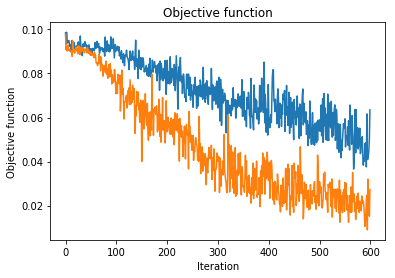

In [19]:
plt.figure()
plt.clf()
plt.xlabel('Iteration')
plt.ylabel('Objective function')
plt.title('Objective function')
plt.plot(range(iters), adam_err)
plt.plot(range(iters), sca_err)

## Fashion Mnist SCA Standard

In [17]:
device,sequence_length,input_size,hidden_size,num_layers,num_classes,batch_size = init_hyper_param()
train = torchvision.datasets.MNIST(root="/home/temp/Error_Lstm/data/",train=True, transform=transforms.ToTensor())
C = 0.00
SSE = 0.0
rho_eps = 0.0
SS,rho, tau  = np.array([2**-0.45944604, 2**-0.27720955, 2**-2.08651111])
iters = 600
lstm_model,parameters = random_initialization_neural_networks(input_size,hidden_size,num_layers,num_classes,device)
sca_model,sca_err,sca_grad,message = sca_ridge(lstm_model,parameters,train,batch_size,sequence_length,input_size,max_it=iters,
                                                      step_size=SS,C=C,tau=tau,rho_eps=rho_eps,step_size_eps=SSE,rho=rho)


In [ ]:
10 41

In [18]:
sca_acc = Valid_Accuracy(sca_model,train,batch_size,sequence_length,input_size)
np.mean(sca_acc)

86.79583

In [20]:
Data_Set = pd.DataFrame()
Data_Set['err'] = pd.Series(sca_err)
Data_Set['grad'] = pd.Series(sca_grad)
Data_Set['acc'] = pd.Series(sca_acc)
Data_Set.to_csv('Fashion_SCA_Standard.csv')